# Dynamic Discrete Choice in Python
## Advanced Quantitative Marketing - Arjun Gopinath

In this Jupyter notebook, I display all relevant results from the switching cost assignment. The model follows Hartmann and Viard (2008).

### Part 1.

We can adapt the problem statement to fit the framework for dynamic discrete choice as defined in class.

The utility function is given by
\begin{gather*}
    U(x, a=j) \; = \; 
    \begin{cases} 
        \delta + \varepsilon_{1t} & j = 1, x < N \\
        \delta + r + \varepsilon_{1t} & j = 1, x = N \\
        \varepsilon_{0t} & j = 0
    \end{cases}
\end{gather*}
This implies that $u_j(x)$ is given by 
\begin{gather*}
    u_j(x) \; = \; \begin{cases} \delta & j = 1, x < N \\ \delta + r & j = 1, x = N \\ 0 & j = 0 \end{cases}
\end{gather*}


The transition probability is given by
\begin{gather*}
    \operatorname{f}\left(x' \, \middle| \, x, a = 1  \right) \; = \; \mathbf{1} \left\{ x' = x + 1 \; \text{and} \; x < N \right\} \times \mathbf{1} \left\{ x' = 0 \; \text{and} \; x = N \right\} \\
    \operatorname{f}\left(x' \, \middle| \, x, a = 0  \right) \; = \; \mathbf{1} \left\{ x' = x \right\}
\end{gather*}



In [1]:
# Frequently used packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import gumbel_r
from scipy.special import logsumexp
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib

# Frequently used commands
inv, ax = np.linalg.inv, np.newaxis

matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.preamble'] =  r'\usepackage{amssymb}' + r'\usepackage{amsmath}' + r'\usepackage{xcolor}' + r'\renewcommand*\familydefault{\sfdefault}'
# matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
# matplotlib.rcParams['pgf.preamble'] = r'\usepackage[utf8x]{inputenc}' + r'\usepackage{amssymb}' + r'\usepackage[T1]{fontenc}' + r'\usepackage{amsmath}' + r'\usepackage{sansmath}'

### Part 2.

To solve for the choice-specific value functions, we first need to solve the integrated Bellman equation to obtain the expected value function. For any $x \in \{0, 1, \ldots, N \}$, we have

\begin{gather*}
    w(x) \; = \; \int \max_{j \in \{0, 1\}} \left\{u_{j}(x) + \epsilon_{j} + \beta \int w\left(x^{\prime}\right) \; \operatorname{f} \left(x^{\prime} \, \middle| \, x, j \right) \text{d} x^{\prime}\right\} \; g(\epsilon) \text{d} \epsilon
\end{gather*}

Here, we assume that $\epsilon \overset{\text{i.i.d.}}{\sim} \operatorname{T1EV}(\mu = -\gamma, \sigma = 1)$. 

\begin{gather*}
    w(x) \; = \; \mu+\gamma+\log \left(\sum_{j \in  \{0, 1\}} \exp \left\{ u_{j}(x)+\beta \int w\left(x^{\prime}\right)  \operatorname{f} \left(x^{\prime} \, \middle| \, x, j \right) \text{d} x^{\prime}\right\} \right)
\end{gather*}

This gives us the choice-specific value function for any $j \in \{0, 1\}$ and $x \in \{0, 1, \ldots, N\}$:
\begin{gather*}
    v_j(x) \; = \; u_j(x) + \beta \int w\left(x^{\prime}\right)  \operatorname{f} \left(x^{\prime} \, \middle| \, x, j \right) \text{d} x^{\prime}
\end{gather*}

In [2]:
def util_mat(δ, r, N):

    """
        Constructs the choice-specific utility functions in this system: U(x,a)
        :param δ: Product valuation
        :param r: Reward
        :param N: Cap on reward points
    """

    util = np.zeros((N+1, 2))
    util[0:N, 1] = δ
    util[N, 1] = δ + r

    return util


def prob_trans(N):

    """
        Constructs the probability transition matrix corresponding to this 
            model: Pr(x'|x, a)
        :param N: Cap on reward points
    """

    prob = np.zeros((N+1, N+1, 2))
    prob[:, :, 0] = np.eye(N+1)

    prob[range(0, N+1), range(-1, N), 1] = 1
    
    for i in range(N + 1): 
        prob[i, i-1, 1] = prob[i-1, i-1, 0]

    return prob


def expBellman_VFI(β=0.95, δ=1, r=0.5, N=10, tol=1e-10, ite_max=10000):

    """
        Performs a Value Function Iteration procedure to arrive at a fixed-point
            solution to the integrated Bellman equation: w(x)

        Also computes the choice-specific value functions: v_j(x)

        :param β: Discount factor
        :param δ: Product valuation
        :param r: Reward
        :param N: Cap on reward points

        :param tol: Fixed point algorithm tolerance
        :param ite_max: Maximum iteration count

    """

    util, prob = util_mat(δ, r, N), prob_trans(N)

    # Initial guess for expected value function
    expectedVF = np.max(util, axis=1)/(1 - β)

    # Setting parameters for the fixed point iteration procedure.
    tol, ϵ, ite = 1e-10, 1, 0

    # Value Function Iteration:
    while ϵ > tol and ite < ite_max:

        # Updating the expected value function through the integrated Bellman.
        updatedVF = logsumexp(a=util + β * np.einsum(
            'i,ijk->jk', expectedVF, prob) , axis=1)

        # Computing norm between updated versions of the expected value function.
        ϵ = norm(updatedVF - expectedVF)

        ite = ite + 1

        ### print('[{:}] norm = {:.4e}'.format(ite, ϵ))

        expectedVF = updatedVF

    # Derive the choice-specific value functions:
    choicespecificVF = util + β * np.einsum('i,ijk->jk', expectedVF, prob)
    
    return expectedVF, choicespecificVF

def switching_cost(CSVF, N):

    """
        Computes the switching cost: c(x)

        :param CSVF: The computed choice-specifc value function.
        :param N: Cap on reward points

    """

    scost = [(CSVF[i, 1] - CSVF[i, 0]) - (CSVF[0, 1] - CSVF[0, 0]) for i in range(N+1)]
    scost = np.asarray(scost)

    return scost

def CCP(CSVF, N):

    """
        Computes the conditional choice probability: \sigma_a(x)

        :param CSVF: The computed choice-specifc value function.
        :param N: Cap on reward points

    """

    ccp = np.zeros(CSVF.shape)

    ccp[:, 0] = np.divide((CSVF[:, 0]), (np.exp(CSVF[:, 0]) + np.exp(CSVF[:, 1])))
    ccp[:, 1] = 1 - ccp[:, 0]

    return ccp


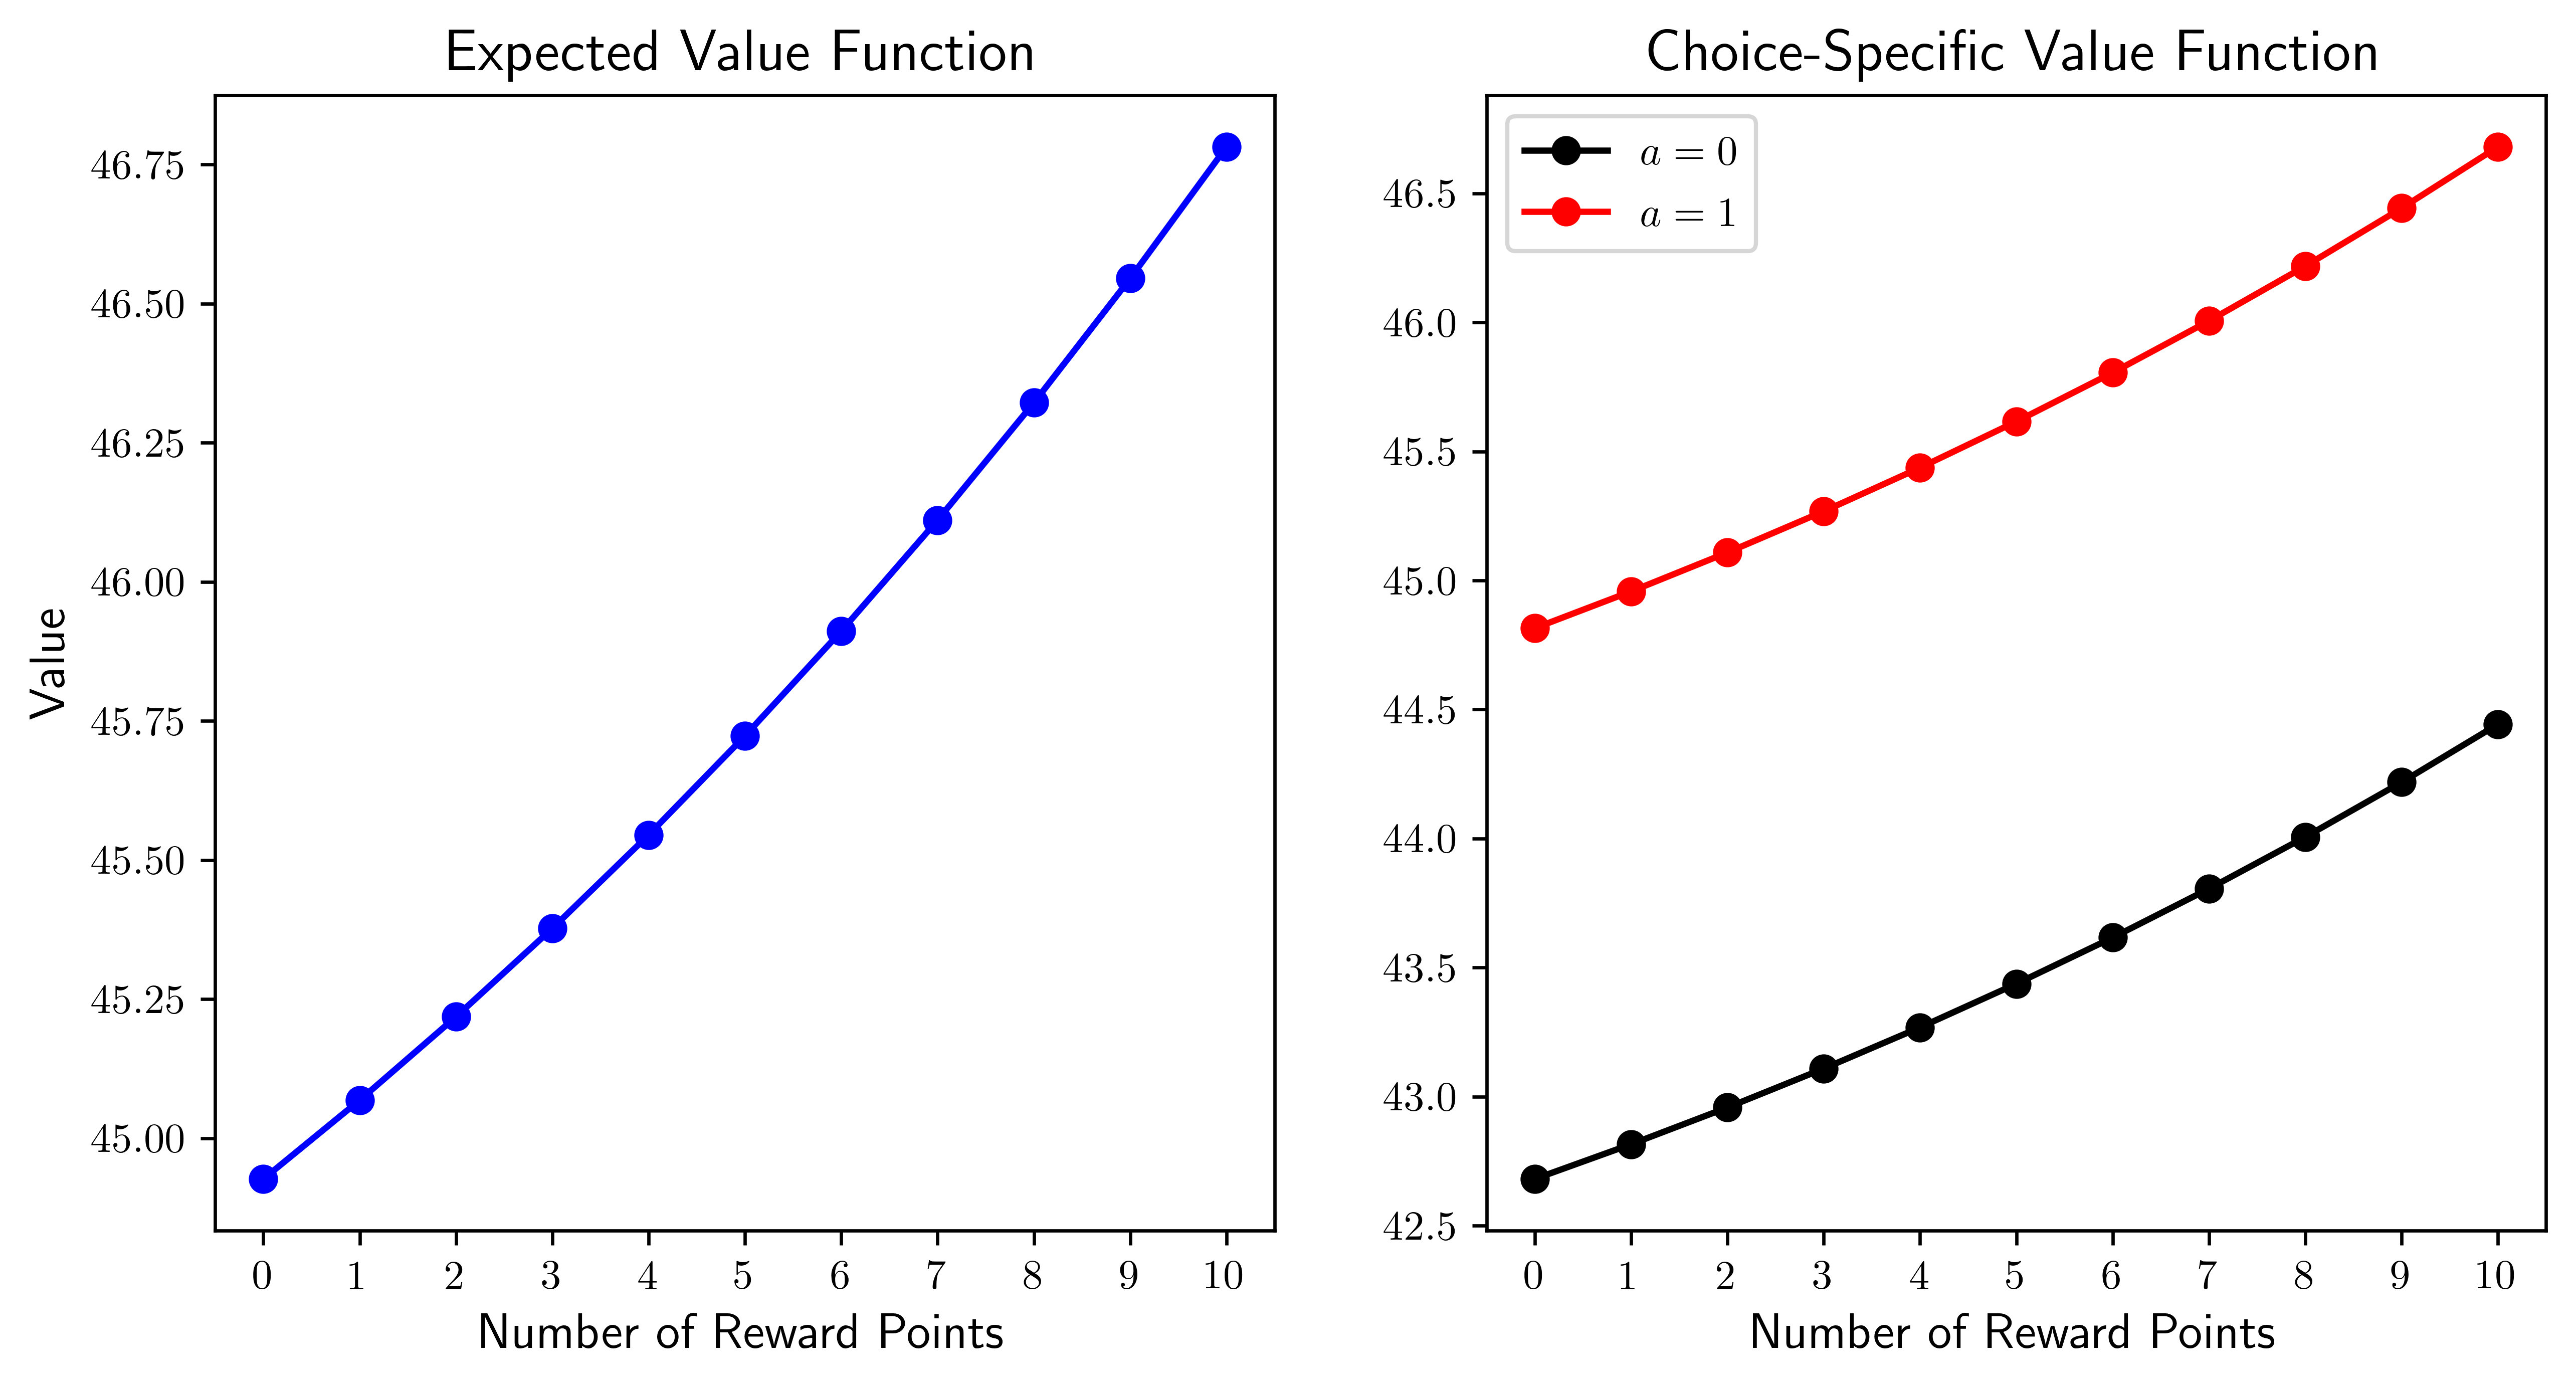

In [3]:
N_model = 10
EVF, CSVF = expBellman_VFI(β=0.95, δ=2, r=2, N=N_model, tol=1e-10, ite_max=10000)

fig0, ax0 = plt.subplots(1, 2, figsize=(10, 5), dpi=600)

ax0[0].plot(range(N_model + 1), EVF.squeeze(), color='b', marker='o')
ax0[0].set_xlabel('Number of Reward Points', fontsize=12);
ax0[0].set_ylabel('Value', fontsize=12);
ax0[0].set_title('Expected Value Function', fontsize=14);
ax0[0].set_xticks(np.arange(start=0, stop=11, step=1));

ax0[1].plot(range(N_model + 1), CSVF[:, 0].squeeze(), label=r'$a = 0$', color='k', marker='o')
ax0[1].plot(range(N_model + 1), CSVF[:, 1].squeeze(), label=r'$a = 1$', color='r', marker='o')
ax0[1].set_xlabel('Number of Reward Points', fontsize=12);
ax0[1].set_title('Choice-Specific Value Function', fontsize=14);
ax0[1].set_xticks(np.arange(start=0, stop=11, step=1));
ax0[1].legend();


### Part 3.

Hartmann and Viard (2008) define the switching cost to be
\begin{gather*}
    c(x) \; \equiv \; \left( v_1(x) - v_0(x) \right) - \left( v_1(0) - v_0(0) \right)
\end{gather*}

The switching cost as formulated captures the effect of how choosing the outside option involves losing the utility from holding the product, after controlling for holding reward points that do not have any value when choosing the outside option. Only using $v_1(x) - v_0(x)$ would lead to a biased version of switching costs as the consumer would lose the loyalty rewards by choosing the outside option. 

### Part 4.

The figure below confirms the intuition laid out in Hartmann and Viard (2008).  Customers who place a higher value on a firm’s reward program by having a higher valuation of the firm's product face lower switching costs because their incentive to start purchasing in the program is as strong as their incentive to continue purchasing once in the program. The figure below proves that switching costs are decreasing in the consumer 'type' for the same amount of loyalty points. However, this holds as long as the reward is strictly positive.

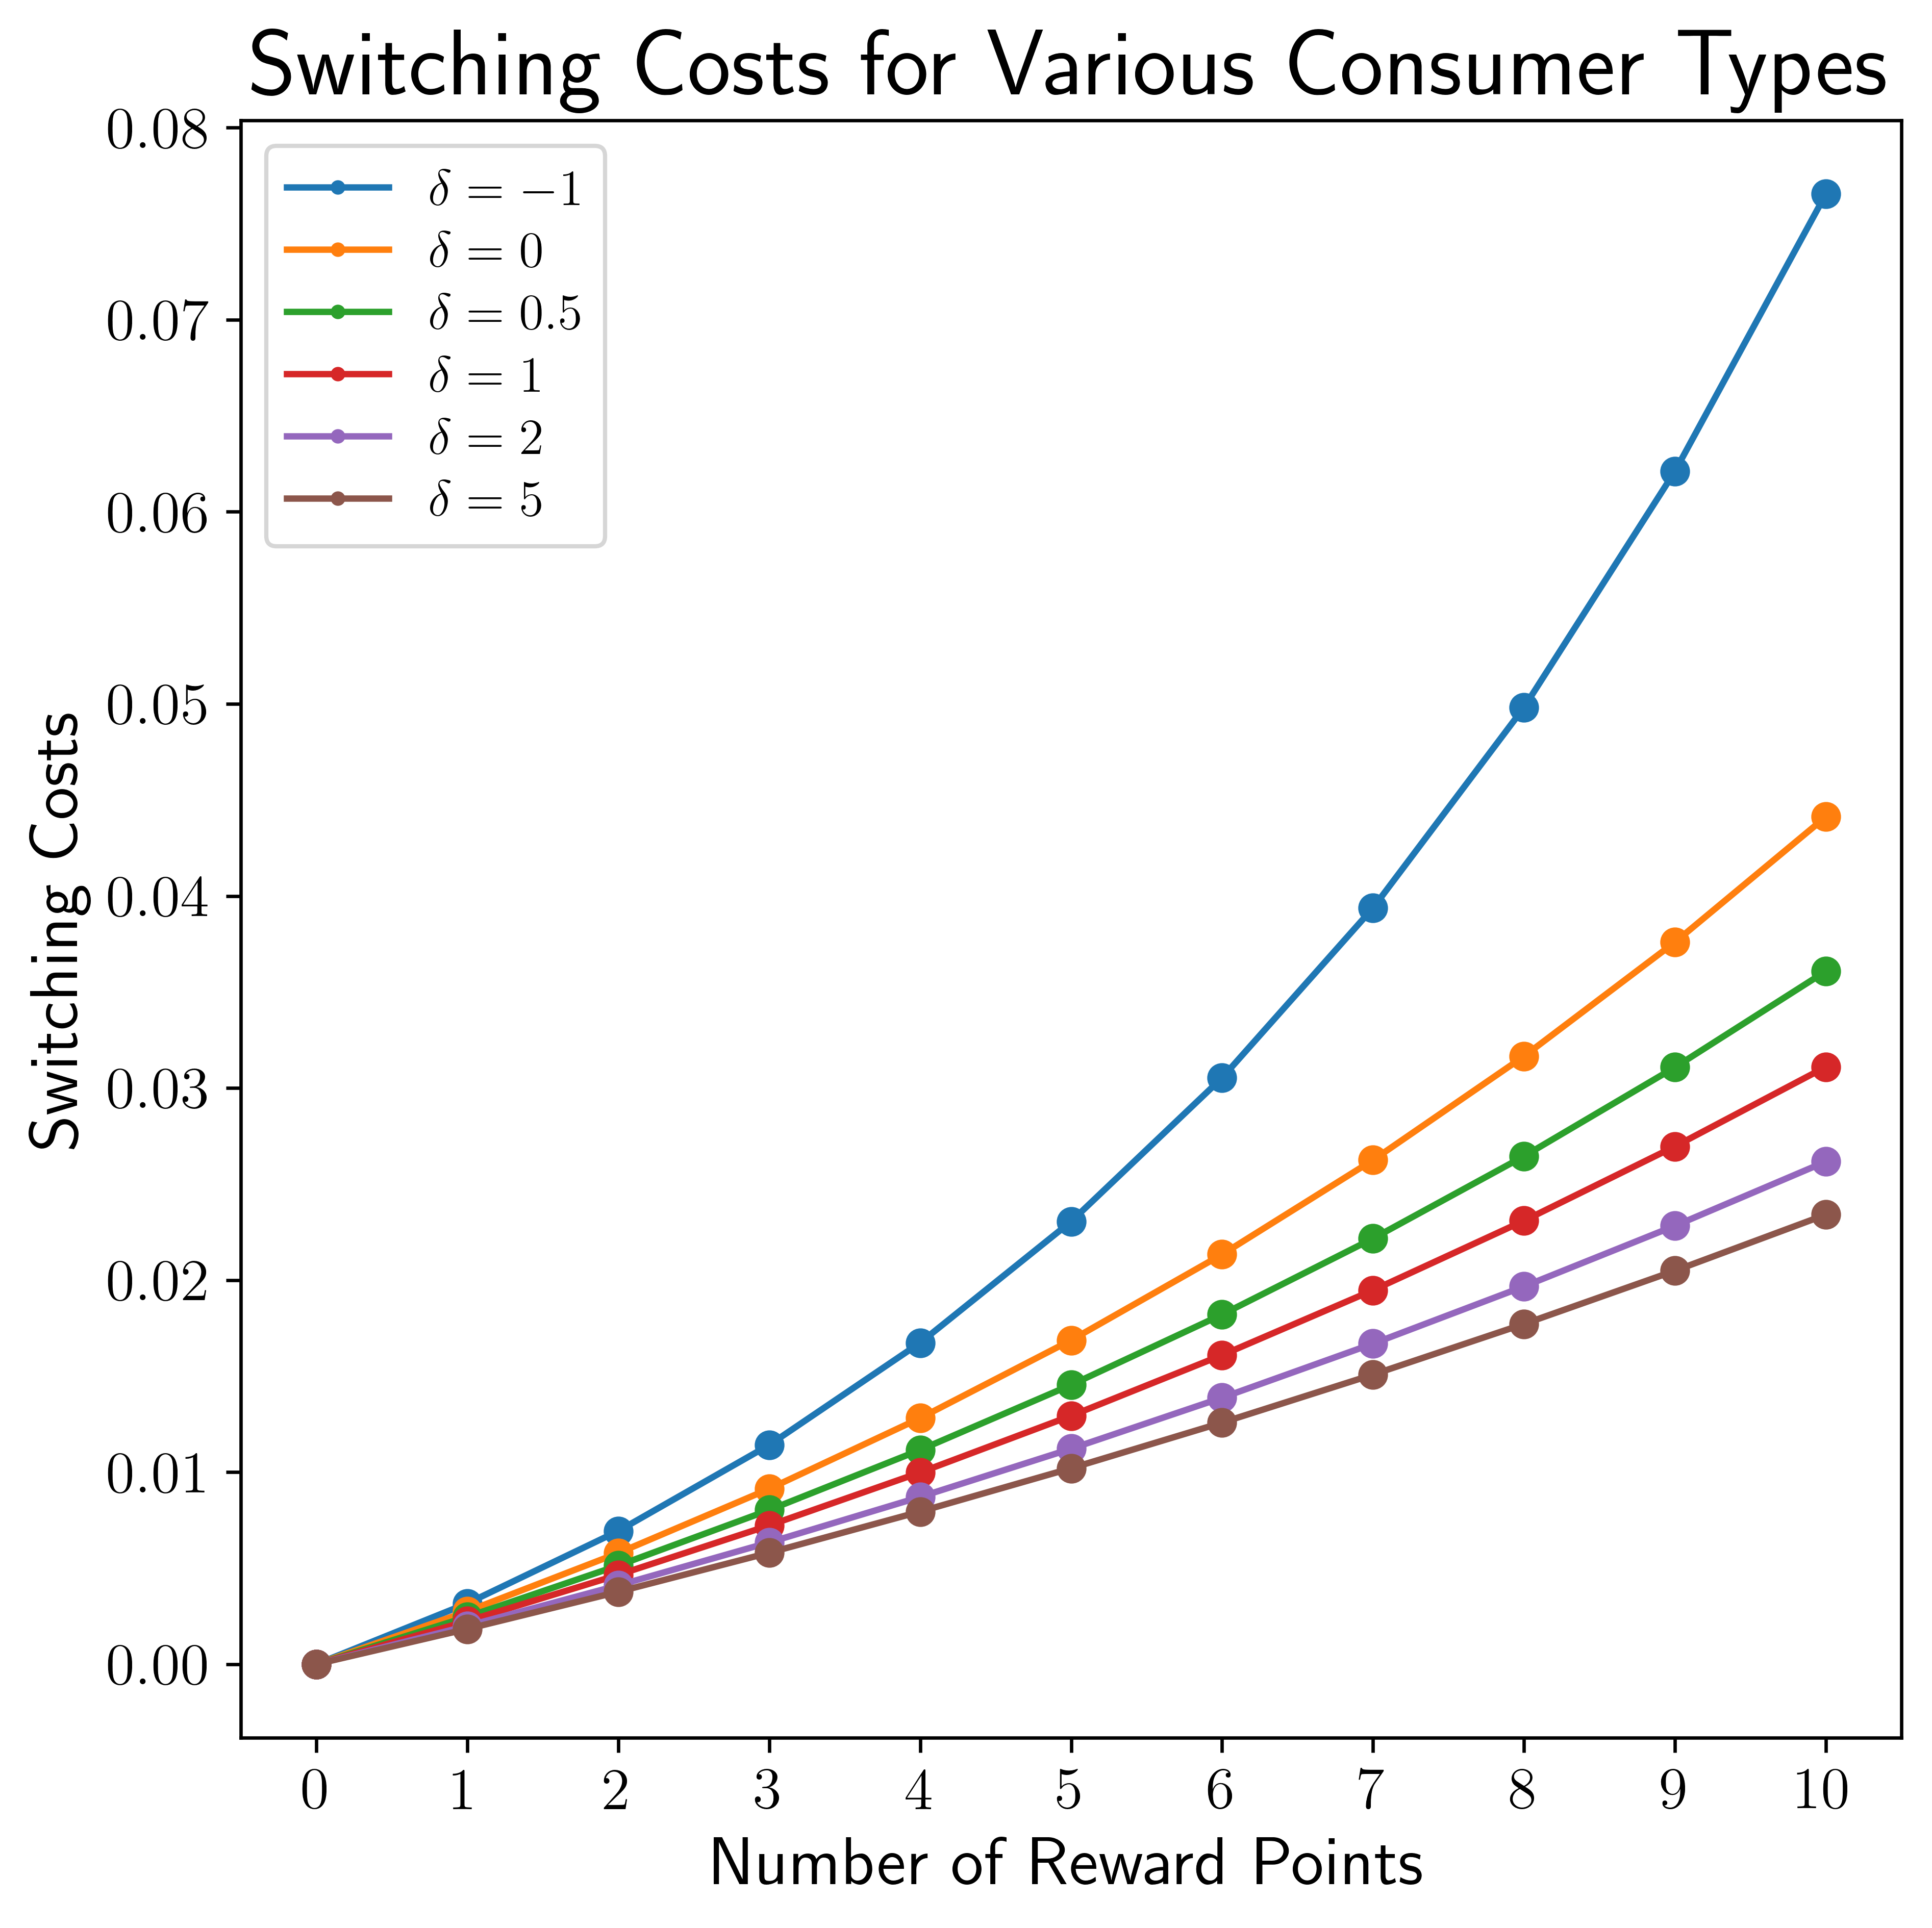

In [4]:
range_δ = [-1, 0, 0.5, 1, 2, 5]
N_model = 10

VF_δ = [switching_cost(expBellman_VFI(δ=d, N=N_model)[1], N=N_model) for d in range_δ]

fig1, ax1 = plt.subplots(figsize=(7, 7), dpi=600)

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.inferno(np.linspace(0, 1, len(range_δ) + 1)))

for ix, d in enumerate(range_δ):
        
    ax1.plot(range(N_model + 1), VF_δ[ix].squeeze(), label= '$\delta = {:}$'.format(d), marker='o')
    
ax1.legend(ncol=1, loc=2, fontsize=12, markerscale=0.4, labelspacing=0.25);
ax1.set_xlabel('Number of Reward Points', fontsize=16);
ax1.set_ylabel('Switching Costs', fontsize=16);
ax1.set_title('Switching Costs for Various Consumer Types', fontsize=22);
ax1.set_xticks(np.arange(start=0, stop=11, step=1))
ax1.set_yticks(np.arange(start=0, stop=0.09, step=0.01))
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

However, this claim is violated when the reward is negative, as seen in the numerical solution below.

In [5]:
range_δ = [-1, 0, 0.5, 1, 2, 5]
N_model = 10
range_r = [2, 0, -1, -2]

fig2, ax2 = plt.subplots(2, 2, figsize=(10, 10), dpi=600)


for ir, reward in enumerate(range_r):

    x2, y2 = int(np.floor(ir/2)), ir % 2

    VF_δ = [switching_cost(expBellman_VFI(δ=d, r=reward, N=N_model)[1], N=N_model) for d in range_δ]

    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.inferno(np.linspace(0, 1, len(range_δ) + 2)))

    for ix, d in enumerate(range_δ):
            
        ax2[x2, y2].plot(range(N_model + 1), VF_δ[ix].squeeze(), label= '$\delta = {:}$'.format(d), marker='o')
    
    ax2[x2, y2].legend(ncol=1, fontsize=8, markerscale=0.4, labelspacing=0.25);
    ax2[x2, y2].set_xlabel('Number of Reward Points', fontsize=12);
    ax2[x2, y2].set_ylabel('Switching Costs', fontsize=12);
    ax2[x2, y2].set_title('$r = {:}$'.format(reward), fontsize=12);
    ax2[x2, y2].set_xticks(np.arange(start=0, stop=11, step=1))
    
    fig2.get_axes()[0].annotate('Varying the Reward Amount', (0.5, 0.95), 
                            xycoords='figure fraction', ha='center', 
                            fontsize=20
                            )
    

The heterogeneity in the cost function is vastly reduced as the discount factor $\beta$ is lowered. As consumers become more myopic, any difference in observed choice is entirely shock-driven and differences between types disappear once these shocks are integrated out. We also notice that the uniform monotonicity of the cost function across the various reward points changes as the discount factor decreases. The decreasing nature of switching costs with respect to type is maintained only when the consumer's holding onto the maximum possible points. Otherwise, the monotonicity is mostly switched around (or the costs are bunched up together) for $x < N$. 

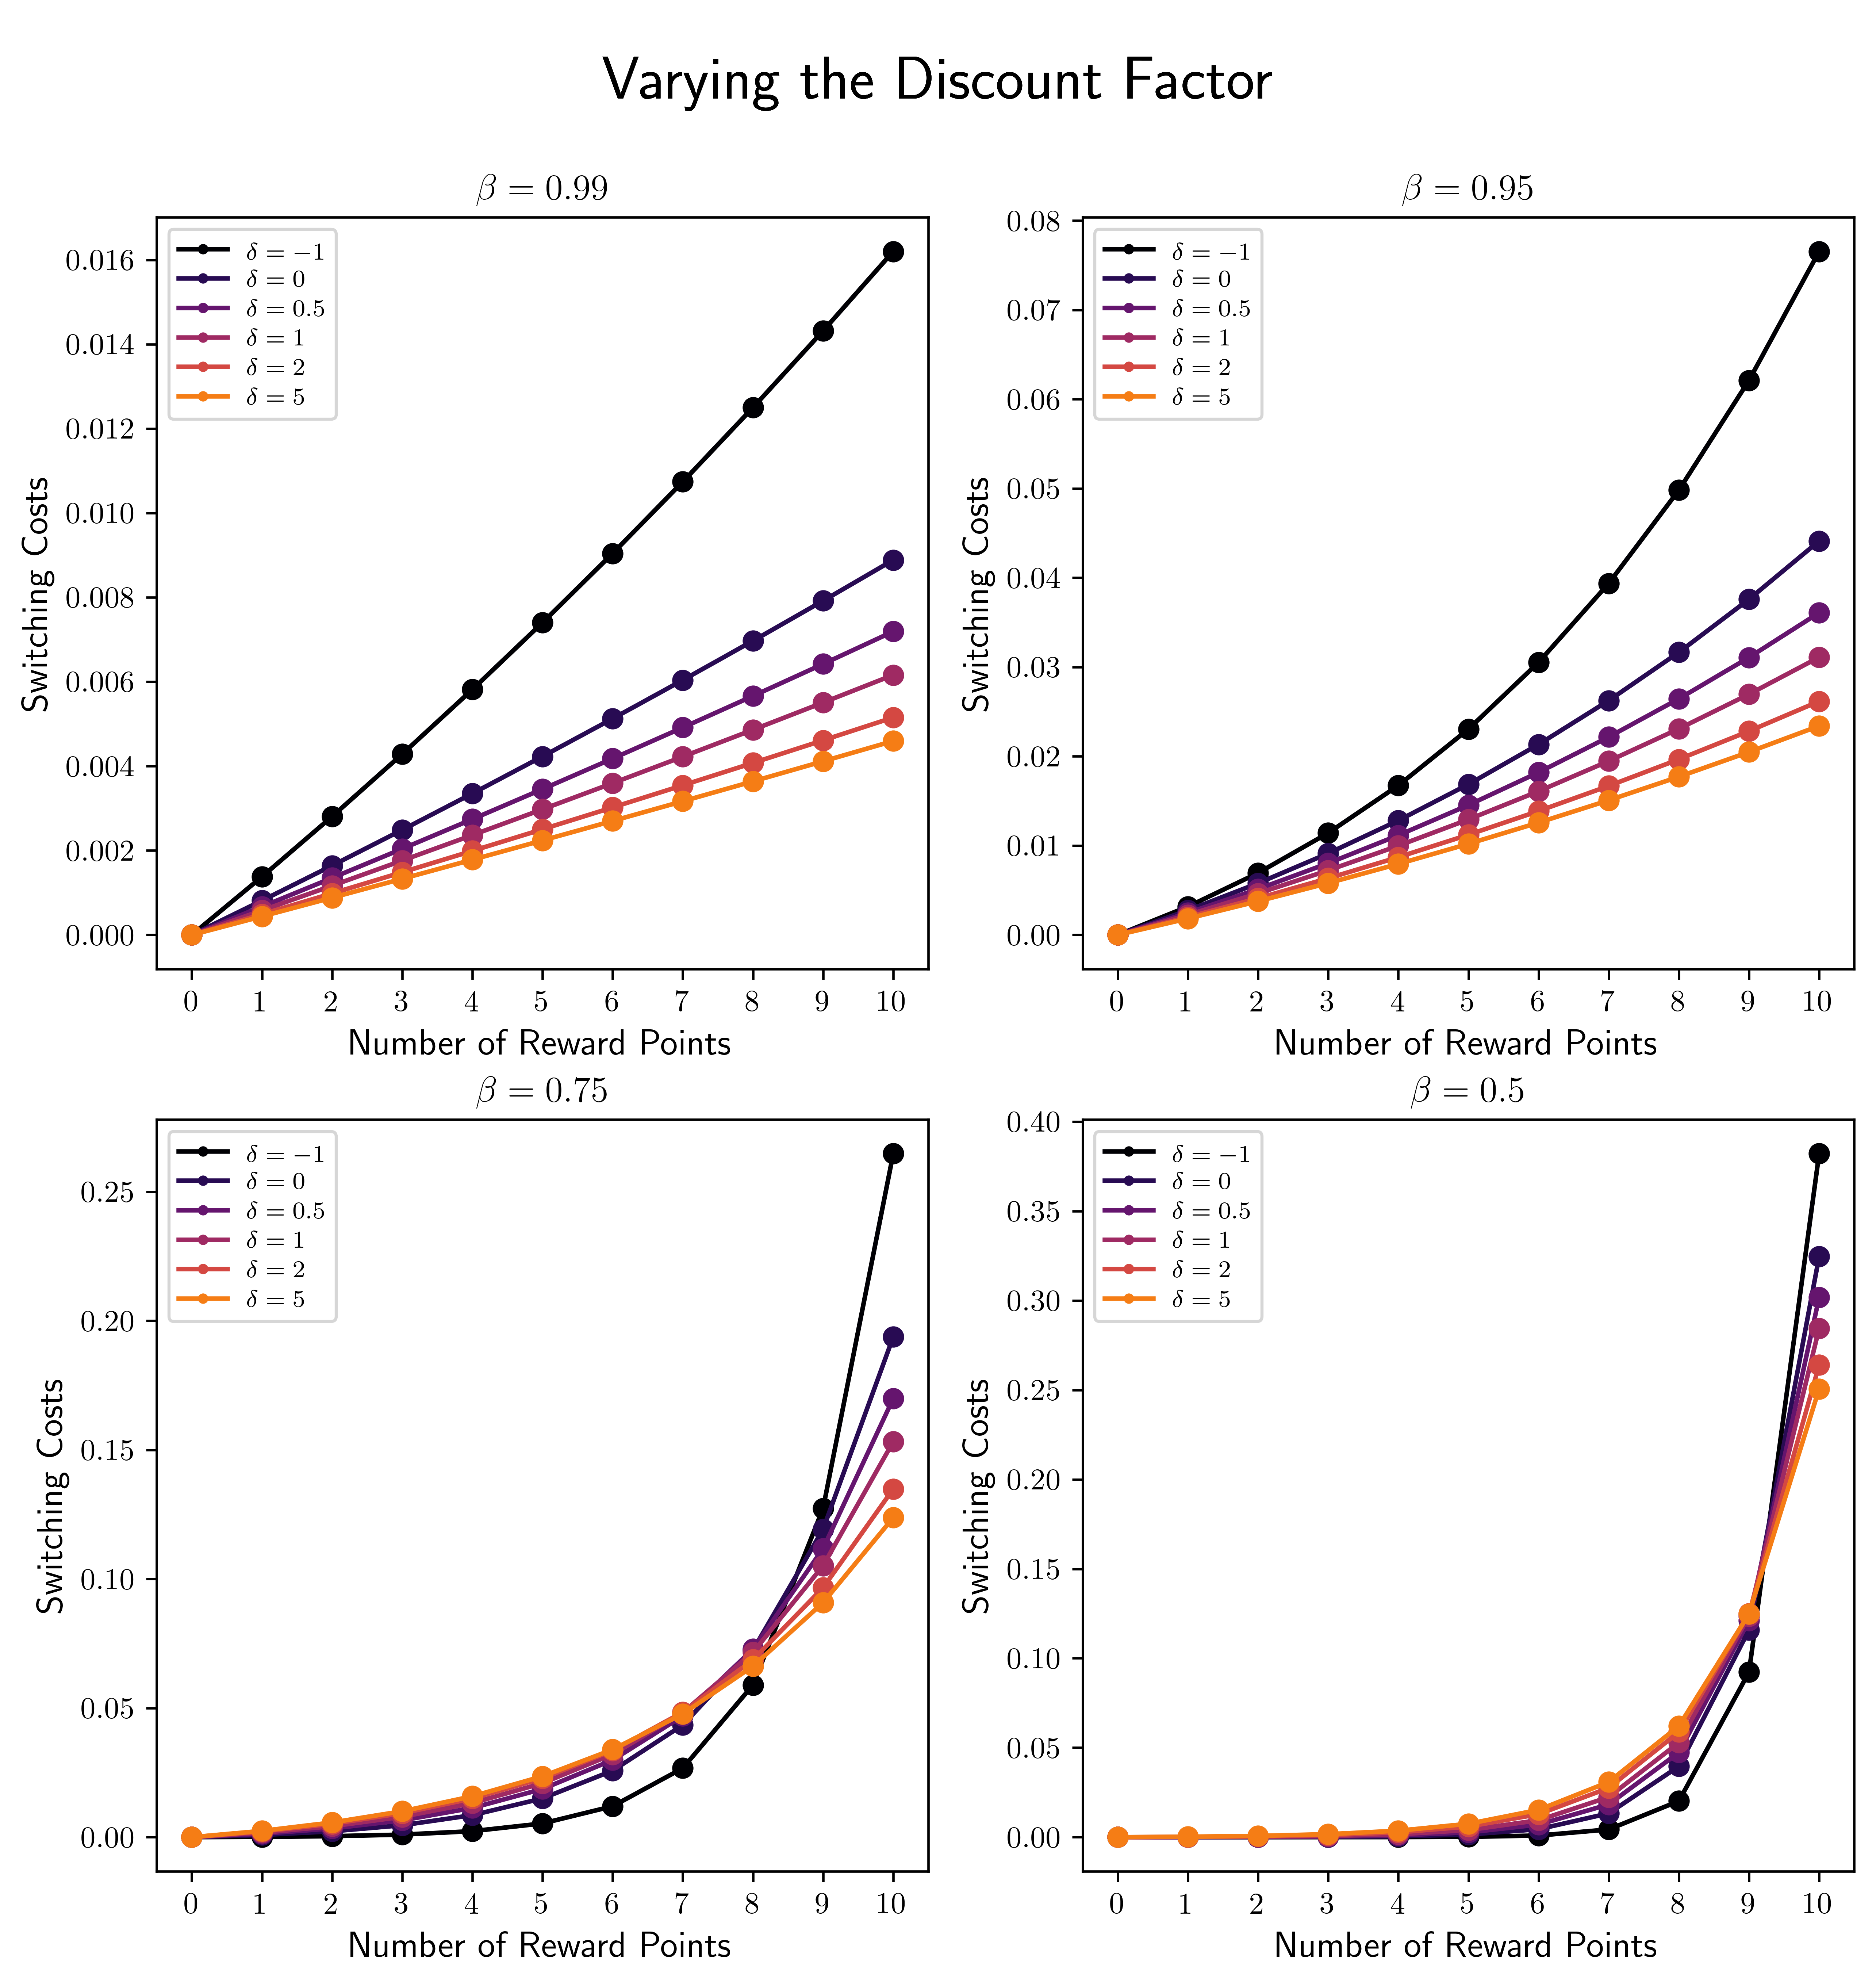

In [6]:
range_δ = [-1, 0, 0.5, 1, 2, 5]
N_model = 10
range_β = [0.99, 0.95, 0.75, 0.5]

fig3, ax3 = plt.subplots(2, 2, figsize=(10, 10), dpi=600)

for iβ, β_val in enumerate(range_β):

    x3, y3 = int(np.floor(iβ/2)), iβ % 2

    VF_δ = [switching_cost(expBellman_VFI(δ=d, β=β_val, N=N_model)[1], N=N_model) for d in range_δ]

    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.inferno(np.linspace(0, 1, len(range_δ) + 2)))

    for ix, d in enumerate(range_δ):
            
        ax3[x3, y3].plot(range(N_model + 1), VF_δ[ix].squeeze(), label= '$\delta = {:}$'.format(d), marker='o')
    
    ax3[x3, y3].legend(ncol=1, fontsize=8, markerscale=0.4, labelspacing=0.25);
    ax3[x3, y3].set_xlabel('Number of Reward Points', fontsize=12);
    ax3[x3, y3].set_ylabel('Switching Costs', fontsize=12);
    ax3[x3, y3].set_title(r'$\beta = {:}$'.format(β_val), fontsize=12);
    ax3[x3, y3].set_xticks(np.arange(start=0, stop=11, step=1))

    fig3.get_axes()[0].annotate('Varying the Discount Factor', (0.5, 0.95), 
                            xycoords='figure fraction', ha='center', 
                            fontsize=20
                            )
  

### Part 5.

The conditional choice probability of choosing to purchase the good given the number of reward points $x$ is given by

\begin{align*}
    \sigma_1(x) \; & = \; \operatorname{Pr} \left\{ v_1(x) + \varepsilon_{1} \; \geq \; v_0(x) + \varepsilon_{0} \right\} \; = \; \operatorname{Pr} \left\{ \varepsilon_{0} - \varepsilon_{1} \; \leq \;  v_1(x) - v_0(x)  \right\}  \\
    & = \; \frac{1}{1 + \exp \left\{ - \left(  v_1(x) - v_0(x) \right) \right\}} \; = \; \frac{\exp \left(v_1(x) \right)}{\exp \left(v_1(x) \right) + \exp \left(v_0(x) \right)}
\end{align*}

Therefore,

\begin{align*}
    \log \sigma_1(x) - \log \sigma_0(x) \; & = \; \log {\exp \left(v_1(x) \right)} - \log{\exp \left(v_0(x) \right)} \; = \; v_1(x) - v_0(x)
\end{align*}

Clearly this implies that

\begin{align*}
    c(x) \; & = \; \left[v_1(x) - v_0(x) \right] - \left[v_1(0) - v_0(0) \right] \\
    & = \;  \left[\log \sigma_1(x) - \log \sigma_0(x) \right] - \left[\log \sigma_1(0) - \log \sigma_0(0) \right] \\
    & = \; \log \left( \frac{\sigma_1(x)}{\sigma_0(x)} \, \middle/\frac{\sigma_1(0)}{\sigma_0(0)}   \right) \\
    \Longrightarrow \;\; \exp \left( c(x) \right) \; & = \; \left( \frac{\sigma_1(x)}{\sigma_0(x)} \, \middle/\frac{\sigma_1(0)}{\sigma_0(0)}   \right)
\end{align*}

This implies that the exponential cost function is the ratio of the odds-ratio of purchasing the product with $x$ rewards points to that of purchasing with $0$ reward points.

### Part 6.

We can compute the average switching cost across the various states using the stationary distribution of the Markov chain $\operatorname{Pr}(x' | x)$. We can use the same distribution to compute the average CCP ratio.


In [7]:
def computeStatDist(CSVF, N):

    """
    Computes the stationary distribution associated with the state space
        given the choice-specific value functions.

        :param CSVF: Choice-specific value function
        :param N: Cap on reward points
    """

    ccp = CCP(CSVF=CSVF, N=N)
    
    CCPmat0 = np.diag(ccp[:, 0])

    CCPmat1 = np.zeros((N+1, N+1))
    CCPmat1[range(0, N+1), range(-1, N)] = 1
    CCPmat1 = np.diag(ccp[:, 1]) @ CCPmat1

    CCPmat = CCPmat0 + CCPmat1

    A = np.append(CCPmat.T - np.eye(N_model+1), np.ones((1, N_model + 1)), axis=0)
    b = (np.array([0] * (N_model + 1) + [1])).T
    stat_dist = np.linalg.solve((A).T.dot(A), (A).T.dot(b))

    return stat_dist


In [8]:
avg_cost1, avg_cost2 = np.zeros(len(range_δ)), np.zeros(len(range_δ))

for ix, d in enumerate(range_δ):

    _, CSVF_d = expBellman_VFI(δ=d, N=N_model)

    cost, ccp, statdist = switching_cost(CSVF_d, N_model), CCP(CSVF_d, N_model), computeStatDist(CSVF_d, N_model)

    avg_cost1[ix], avg_cost2[ix] = cost.dot(statdist), np.log(ccp[:, 1]/ccp[:, 0]).dot(statdist)


In [9]:
res_6 = pd.DataFrame({'δ': range_δ, 'Avg c(x)': avg_cost1, 'Log-avg CCP ratio': avg_cost2})

print(res_6)

     δ  Avg c(x)  Log-avg CCP ratio
0 -1.0  0.029039           4.683001
1  0.0  0.018938          11.712597
2  0.5  0.015938          17.105513
3  1.0  0.013979          23.691968
4  2.0  0.011964          39.623687
5  5.0  0.010803          96.473255


From the table above, it is clear that the average switching cost (computed using the stationary distribution associated with the reward points) is decreasing in the consumer type parameterized by $\delta$. 

The average CCP ratio $\sigma_1(x)/\sigma_0(x)$ also works to represent consumer type, since it is strictly increasing in $\delta$. It is represented here on a log-scale to improve readability. Also, the average switching cost is decreasing in the average CCP ratio, which confirms the Hartmann and Viard (2008) conjecture about switching costs.